In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import statsmodels
from sklearn.metrics import confusion_matrix
# No warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import du csv
billets = pd.read_csv('billets.csv', sep=';')

In [3]:
# Vérification de la taille du dataframe
billets.shape

(1500, 7)

In [4]:
# Resume des donnees brutes:
billets.info()
billets.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Nous avons bien six dimensions en plus de la colonne permettant de distinguer les vrais, des faux billets qui ne sera pas présente dans nos données réelles.

Les types des données sont ceux attendus.

Il manque des données seulement pour margin_low, il s'agit de la marge entre le bord inferieur du billet et l'image de celui-ci (en mm).

In [5]:
# vérifier les valeurs que prend la colonne is_genuine
billets['is_genuine'].unique()

array([ True, False])

In [6]:
# Vérification des valeurs nulles
print(pd.isnull(billets).sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


37 valeurs nulles sur la colonne margin_low, on verra par la suite le traitement à faire.

In [7]:
#billets.fillna (0,inplace = True)

In [8]:
#billets.isna().sum()

In [9]:
#Verifier le nombre de billets vrais et faux
billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Les résultats sont ceux attendus. 

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         492        500     500
True            1000         1000          1000         971       1000    1000


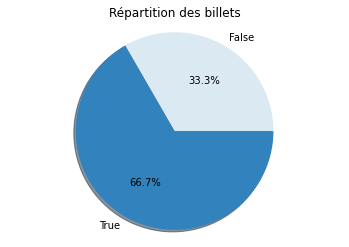

In [10]:
# Repartition des vrais/faux billets dans notre dataset d'apprentissage:
print(billets.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(billets.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()

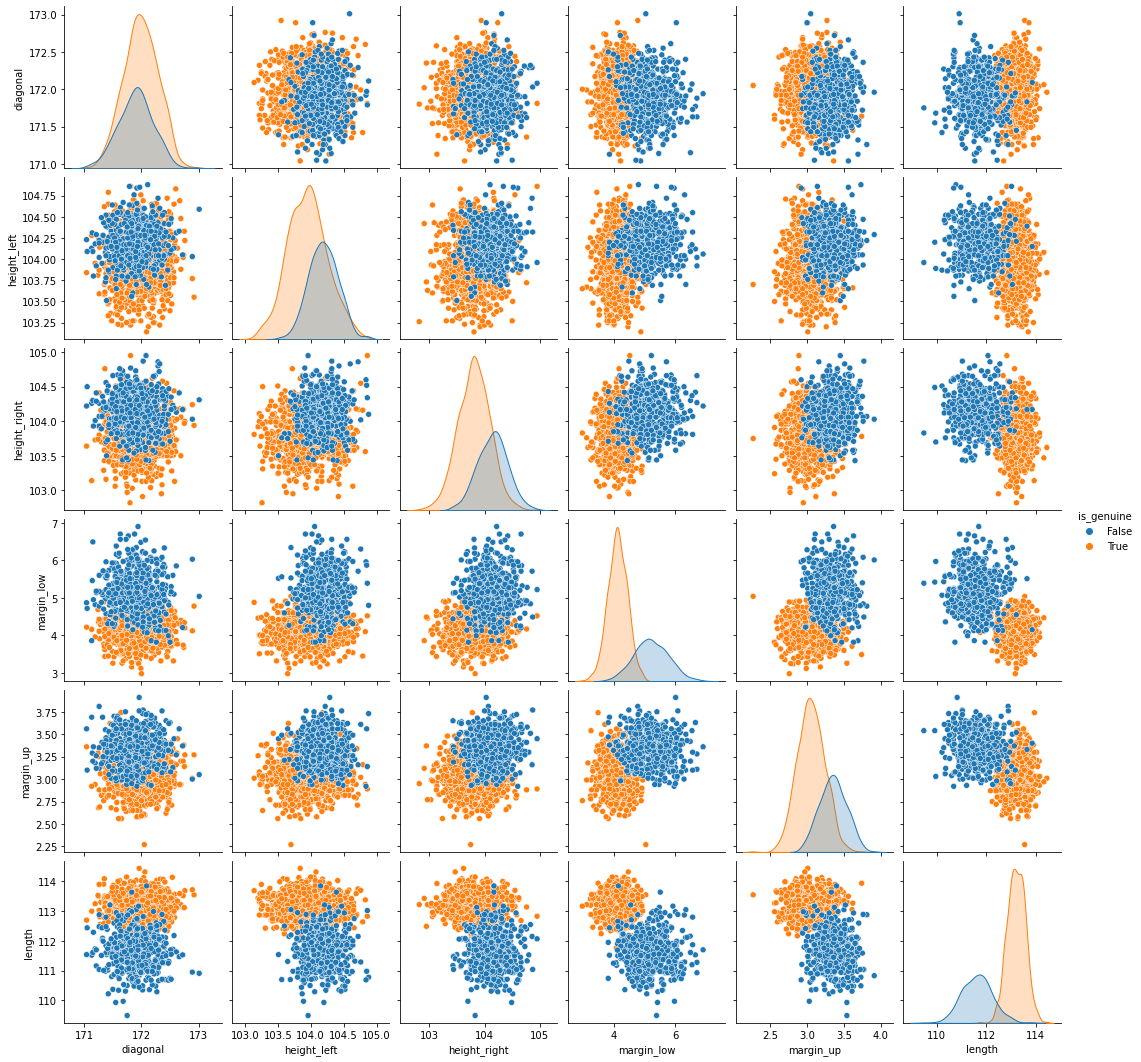

In [11]:
# Pairplot de nos variables selon la validité du billet
sns.pairplot(billets,hue = "is_genuine" )


Les vrais et faux billets se confondent, on le voit avec la superposition de chacune des représentations graphiques. Il y a peut etre des valeurs suspectes à verifier.

On verifiera cette hypothèse ensuite en calculant la p-value de chacune.

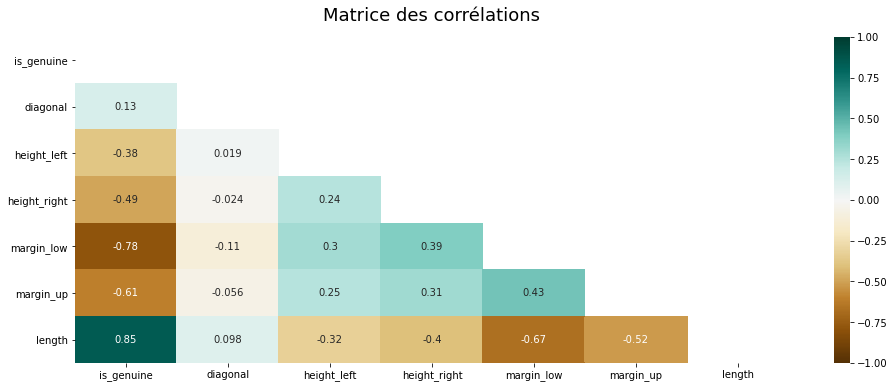

In [12]:
#On regarde la corrélation des données choisies, si elles sont trop corrélées il faut en changer.
#On regarde la force et le sens de correlation

corr_df = billets.corr(method='pearson')

plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Matrice des corrélations', fontdict={'fontsize':18}, pad=16);

<AxesSubplot:xlabel='is_genuine', ylabel='margin_low'>

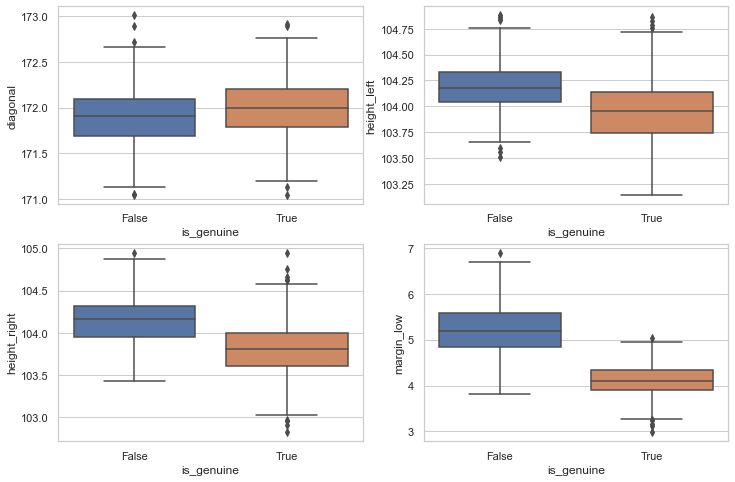

In [13]:
# Afficher des boxplot

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal',x='is_genuine')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left',x='is_genuine')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right',x='is_genuine')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low',x='is_genuine')

<AxesSubplot:xlabel='is_genuine', ylabel='length'>

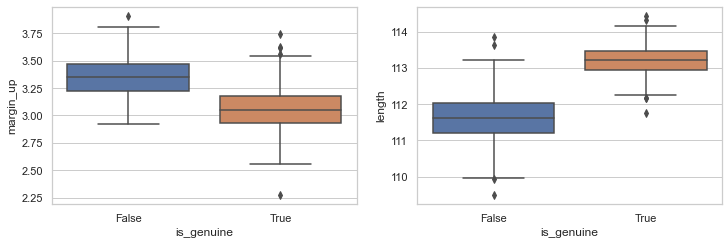

In [14]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up',x='is_genuine')
plt.subplot(222)
sns.boxplot(data=billets,  y='length',x='is_genuine')

In [15]:
from sklearn.linear_model import LinearRegression
#Split les valeurs
to_keep_col = [
    "diagonal",
    "height_left",
    "height_right",
    "margin_up",
    "length",
]
target_col = ["margin_low"]

X_train = billets.loc[~billets["margin_low"].isnull(), to_keep_col]
X_test = billets.loc[billets["margin_low"].isnull(), to_keep_col]

Y_train = billets.loc[~billets["margin_low"].isnull(), target_col]
Y_test = billets.loc[billets["margin_low"].isnull(), target_col]

# Création du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, Y_train)

# Prediction des valeurs
y_pred = model.predict(X_test)
y_pred[:10]

array([[4.31852466],
       [4.39366755],
       [4.41045663],
       [4.31901423],
       [4.6506171 ],
       [3.80330831],
       [4.17973608],
       [4.12744154],
       [4.13503418],
       [4.16053851]])

In [16]:
# Remplacement des nan
billets.loc[billets["margin_low"].isnull(), target_col] = y_pred
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


##### Regression linéaire multiple pas à pas 
Plus destinée à un grand jeu de donnée et/ ou s'il y une difference à combler entre R² et R² ajusté

In [17]:
#Regression linéaire multiple 
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     400.9
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          7.27e-307
Time:                        12:57:19   Log-Likelihood:                -783.95
No. Observations:                1500   AIC:                             1582.
Df Residuals:                    1493   BIC:                             1619.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3038      8

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le  𝑅2
  vaut environ 0.62, et le  𝑅2
  ajusté est d'environ 0.61.

Cette valeur est plus élevée qu'en régression linéaire simple, et c'est logique, car lorsque l'on rajoute des variables explicatives potentielles, on accroît naturellement la valeur de ces  𝑅2 .

#### Retirez les variables non significatives

On va donc maintenant retirer les variables non significatives. On commence par la moins significative : diagonal, avec une p-valeur de 0.670, qui est la moins significative. On l'enlève donc.

On voit alors que c'est maintenant length, car elle a une p-value de 0.458.

In [18]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     601.7
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          1.74e-309
Time:                        12:57:19   Log-Likelihood:                -784.32
No. Observations:                1500   AIC:                             1579.
Df Residuals:                    1495   BIC:                             1605.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0295      5

In [19]:
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     481.1
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          4.15e-308
Time:                        12:57:19   Log-Likelihood:                -784.23
No. Observations:                1500   AIC:                             1580.
Df Residuals:                    1494   BIC:                             1612.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3450      7

On voit alors que c'est maintenant height_left, avec une p-valeur de 0.433, qui est la moins significative. On l'enlève donc.

In [20]:
reg_multi = smf.ols('margin_low~is_genuine+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     802.3
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          7.70e-311
Time:                        12:57:19   Log-Likelihood:                -784.63
No. Observations:                1500   AIC:                             1577.
Df Residuals:                    1496   BIC:                             1599.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.8774      3

On voit alors que c'est maintenant height_right, avec une p-valeur de 0.306, qui est la moins significative. On l'enlève donc

In [21]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1203.
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          3.32e-312
Time:                        12:57:19   Log-Likelihood:                -785.15
No. Observations:                1500   AIC:                             1576.
Df Residuals:                    1497   BIC:                             1592.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.8281      0

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au  𝑅2
 , il vaut environ 0.62, tout comme le  𝑅2
  ajusté.

##### On peut donc utiliser ce modèle à des fins de prévision !

### Analyse des résultats de la régression linéaire

In [22]:
#Rappel du résultat obtenu
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1203.
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          3.32e-312
Time:                        12:57:19   Log-Likelihood:                -785.15
No. Observations:                1500   AIC:                             1576.
Df Residuals:                    1497   BIC:                             1592.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.8281      0

<AxesSubplot:ylabel='margin_up'>

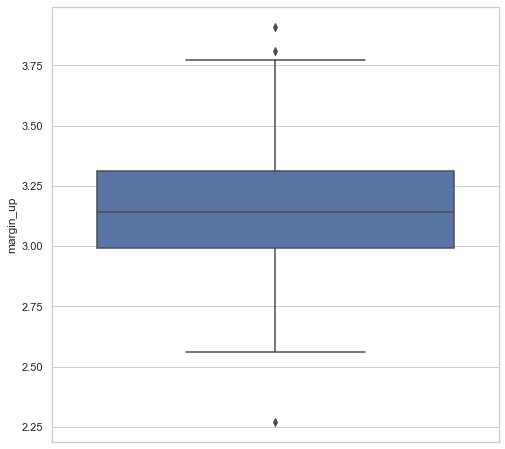

In [23]:
# Affichage des données de margin_up en boxplot
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
sns.boxplot(data=billets,  y='margin_up')

In [24]:
# Nous supprimons les valeurs atypiques de la variable margin_up
billets=billets.loc[(billets['margin_up']>2.30) & (billets['margin_up']<3.75)]

In [25]:
# Suppressions des colonnes que l'on a jugé inutiles lors de la regression linéaire pour le mettre sous forme de df 
bi= billets.drop(['diagonal','length','height_right','height_left'],axis=1)

# vérification de la supression des valeurs manquantes
bi.head()

,is_genuine,margin_low,margin_up
0,True,4.52,2.89
1,True,3.77,2.99
2,True,4.40,2.94
3,True,3.62,3.01
4,True,4.04,3.48


In [26]:
# Fit des données de la régression linéaire pas à pas
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=bi).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1202.
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          1.57e-311
Time:                        12:57:20   Log-Likelihood:                -775.98
No. Observations:                1493   AIC:                             1558.
Df Residuals:                    1490   BIC:                             1574.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.8151      0

In [27]:
x_regr=bi.loc[:,['is_genuine','margin_up']]
ytest=billets['margin_low']

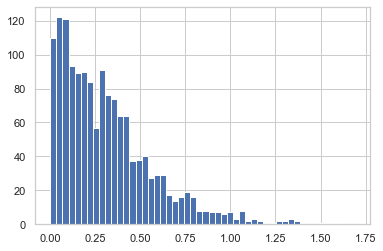

In [28]:
# Représenter les erreurs avec un histogramme
y_pred=reg_multi.predict(x_regr)
erreur_hi=np.abs(ytest-y_pred)
plt.hist(erreur_hi,bins=50)
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, median_absolute_error

print("Mean Absolute Error MAE : ", mean_absolute_error(ytest,y_pred ))
print("Erreur Quadratique Moyenne RMSE : ", np.sqrt(mean_squared_error(ytest,y_pred)) ) #Plus robuste puisqu'il met les valeurs au carré
print("Median Absolute Error : ", median_absolute_error(ytest,y_pred ))
print("Coefficient de Determination R2 : ", r2_score(ytest,y_pred ))

Mean Absolute Error MAE :  0.31253464949611126
Erreur Quadratique Moyenne RMSE :  0.40689729353424786
Median Absolute Error :  0.25804404439603523
Coefficient de Determination R2 :  0.6173385242901954


In [30]:
# Moyenne des résidus
moy=ytest-y_pred
moy.mean()

2.485471826863445e-15

In [31]:
# Test normalité des résidus avec Shapiro
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9932305812835693, pvalue=2.4266898890346056e-06)

L'hypothèse de normalité est remise en cause, pvalue < 5% 

<AxesSubplot:ylabel='Count'>

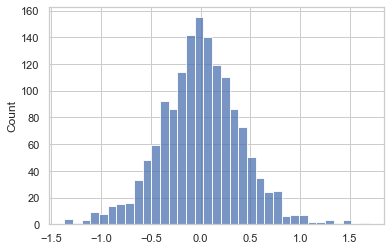

In [32]:
# Representation graphique de notre régression linéaire
sns.histplot(reg_multi.resid)

La distribution est symetrique avec une moyenne vers 0 

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien

In [33]:
#Vérifier la colinéarité des variables
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.573224363016278, 1.5732243630162788]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [34]:
# Testez l’homoscédasticité, c'est-à-dire la constance de la variance) des résidus :

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.353594480274933e-36


La p-value ici est inférieure à  5
 %, on rejette l'hypothèse H0
  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

In [35]:
# Composition de X_train
X_train.shape

(1463, 5)

In [36]:
# Composition de X_test
X_test.shape

(37, 5)

In [37]:
# Composition de Y_train
Y_train

,margin_low
0,4.52
1,3.77
2,4.40
3,3.62
4,4.04
...,...
1495,4.42
1496,5.27
1497,5.51
1498,5.17


Text(0.5, 1.0, 'Matrice de confusion Regression linéaire')

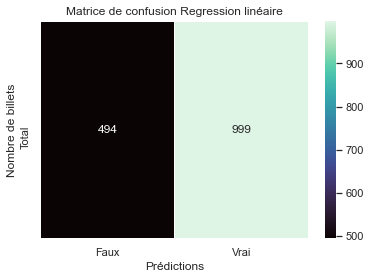

In [38]:
# Graphique : Matrice de confusion pour la régression linéaire
reg_matrix = pd.crosstab(reg_multi,billets["is_genuine"])
sns.heatmap(reg_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels = ['Total']
           
            )
plt.xlabel("Prédictions")
plt.ylabel('Nombre de billets')
plt.title("Matrice de confusion Regression linéaire")

## Classification

In [39]:
# Import des librairies pour la classification

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as Knn
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

In [40]:
# dataset pour notre classification
data = billets.copy()

# splitting the data

from sklearn.model_selection import train_test_split

col_to_keep = [
    "diagonal",
    "height_left",
    "height_right",
    "margin_low",
    "margin_up",
    "length",
]
target_col = "is_genuine"

X = data.loc[:, col_to_keep]
Y = data.loc[:, target_col]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0
)

In [41]:
# Composition de Y
Y

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1493, dtype: bool

##### Regression logistique

In [42]:
# Création du modèle 
model_log = LogisticRegression()
log_reg = model_log.fit(X_train,Y_train)

In [43]:
# Prediction du modèle
y_pred_lr = log_reg.predict(X_test)

In [44]:
#Score pour connaitre la performance du modèle
score = log_reg.score(X_test, Y_test)
print(score)

0.9899665551839465


In [45]:
score = round(score, 2)
print(score)

0.99


In [46]:
print((score)*100,'%')

99.0 %


Notre modèle a une performance 97%, ce qui est exceptionnel mais peu étonnant au vu de notre jeu de données

In [47]:
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

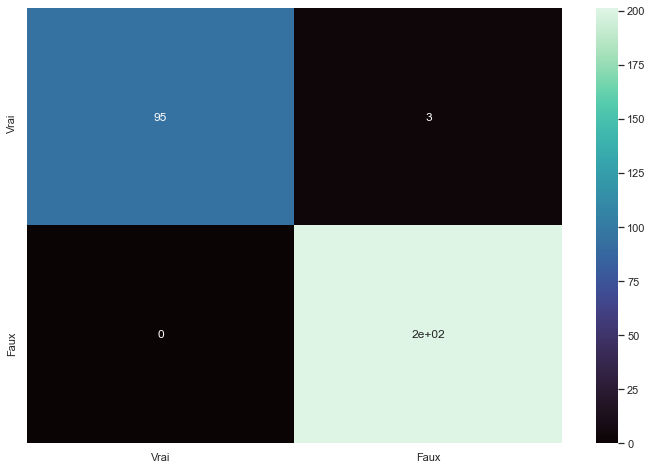

In [48]:
# Matrice de confusion de la régression logistique
fig = plt.figure(figsize=(12,8))
cf_matrix = confusion_matrix(Y_test, y_pred_lr)
sns.heatmap(cf_matrix, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='mako')

###### Réalisation du KNN ( le plus proche voisin)

In [49]:
# Création du modèle
KNN = Knn().fit(X_train,Y_train)
y_pred_knn = KNN.predict(X_test)

In [50]:
# Prédiction
y_pred_knn = KNN.score(X_test,Y_test)
print(score)

0.99


In [51]:
print((score)*100,'%')

99.0 %


Le résultat du du modèle est de 97% de chance d'avoir de bonnes prédictions.

<AxesSubplot:>

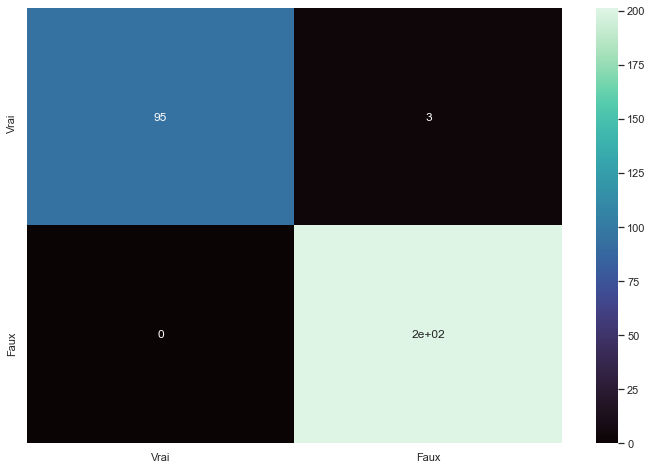

In [52]:
# Matrice de confusion de KNN
fig = plt.figure(figsize=(12,8))
cf_matrix = confusion_matrix(Y_test, KNN.predict(X_test))
sns.heatmap(cf_matrix, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='mako')

##### Réalisation d'un clustering K-means

Afin de trouver le bon nombre de clusters à afficher pour l'algorithme KMeans, on peut identifier le nombre de clusters pour lequel l'inertie intra-classe sera minimisée. On peut alors visualiser ces données et sélectionner le nombre optimal de classes dans notre cas.

In [53]:
from sklearn.cluster import KMeans, AgglomerativeClustering

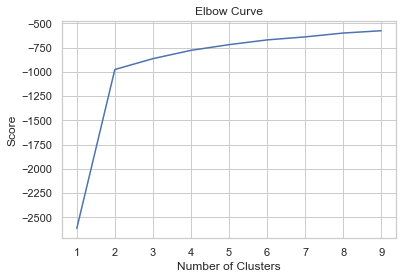

In [54]:
# Run a number of tests, for 1, 2, ... num_clusters
#n_cluster pour connaître le nombre de cluster dont nous avons besoin
num_clusters = 10
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)] 
score = [kmeans_tests[i].fit(billets).score(billets) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Nous voyons bien une cassure nette à 2 , il y a donc 2 clusters et k=2

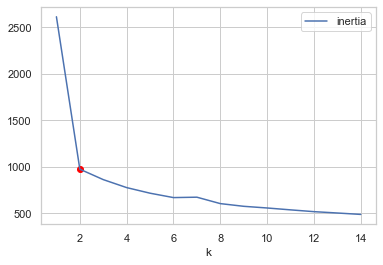

In [55]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 10).fit(billets) #n_cluster pour connaître le nombre de cluster dont nous avons besoin
    inertia = inertia + [kmeans.inertia_]
inertia = pd.DataFrame({"k": range(1, 15), "inertia": inertia})
inertia.plot.line(x = "k", y = "inertia")
plt.scatter(2, inertia.query('k == 2')["inertia"], c = "red")
plt.show()

Le nombre de cluster que nous devons prendre se situe bien à 2 , et est symbolisé par le point rouge sur le graphique

In [56]:
# Création du modèle de clustering k-means
kmeans = KMeans(init='random', n_clusters=2, n_init=10)

# Fit les données au modèle
kmeans.fit(billets)

# Determiner à quel cluster chaque données corresponds
clusters2 =  kmeans.predict(billets)
clusters2

array([1, 1, 1, ..., 0, 0, 0])

In [57]:
# Calcul des centroïdes
centroids = kmeans.cluster_centers_
centroids

array([[-1.22124533e-15,  1.71900392e+02,  1.04191464e+02,
         1.04143155e+02,  5.22933905e+00,  3.34461856e+00,
         1.11606660e+02],
       [ 9.91071429e-01,  1.71986736e+02,  1.03950853e+02,
         1.03811399e+02,  4.11938842e+00,  3.05559524e+00,
         1.13199107e+02]])

In [58]:
# Ajouter le numéro du cluster au df
billets_clustered = pd.DataFrame(billets, columns=billets.columns)
billets_clustered['cluster'] = clusters2

billets_clustered.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


<AxesSubplot:xlabel='cluster', ylabel='margin_low'>

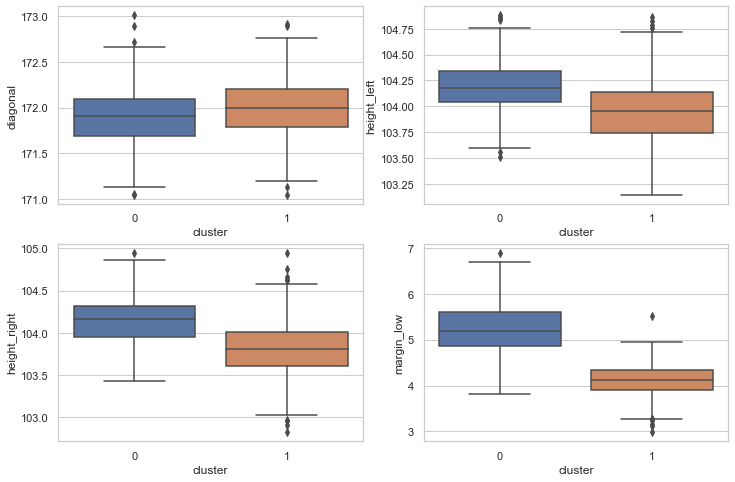

In [59]:
# Afficher des boxplot des clusters
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets_clustered,y='diagonal',x="cluster")
plt.subplot(222)
sns.boxplot(data=billets_clustered, y='height_left',x="cluster")
plt.subplot(223)
sns.boxplot(data=billets_clustered, y='height_right',x="cluster")
plt.subplot(224)
sns.boxplot(data=billets_clustered,y='margin_low',x="cluster")

<AxesSubplot:xlabel='cluster', ylabel='length'>

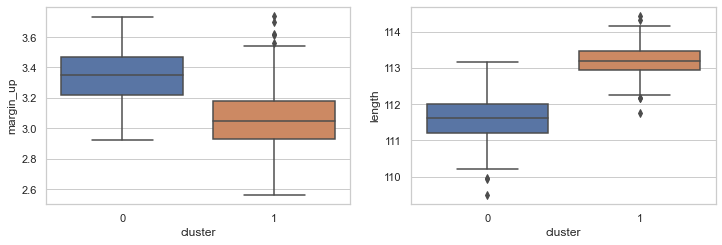

In [60]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets_clustered,  y='margin_up',x="cluster")
plt.subplot(222)
sns.boxplot(data=billets_clustered,  y='length',x="cluster")

In [61]:
# Afficher la composition du cluster 0
cluster_0 = billets_clustered.loc[billets_clustered['cluster'] == 0]
cluster_0

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
1000,False,172.28,103.95,103.91,4.78,3.31,111.40,0
1001,False,171.92,103.86,104.30,4.96,3.13,111.29,0
1002,False,171.59,104.14,104.38,4.97,3.47,111.22,0
1003,False,172.02,104.33,104.33,5.19,3.21,111.99,0
1004,False,172.55,104.25,104.23,5.60,3.13,111.72,0
...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,0
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,0
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,0
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,0


Le cluster 0 regroupe tous les faux billets 

In [62]:
# Afficher la composition du cluster 1
cluster_1 = billets_clustered.loc[billets_clustered['cluster'] == 1]
cluster_1

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1
...,...,...,...,...,...,...,...,...
1160,False,172.39,104.05,104.32,4.13,3.41,112.66,1
1190,False,171.45,104.21,104.18,4.55,3.52,113.21,1
1325,False,171.83,104.39,104.17,5.51,3.33,113.64,1
1407,False,172.02,103.99,104.28,4.22,2.98,112.42,1


Le cluster 1 est censer regrouper tous les vrais billets mais on voit l'apparition de false, ce qui est anormal, il faut pousser l'analyse.

In [63]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-5,5])
            plt.ylim([-5,5])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [64]:
from sklearn.decomposition import PCA

# Selectionner le nombre de composantes principales que nous voulons
num_components = 2

# Créer le modèle de l'ACP
pca = PCA(n_components=num_components)

# Fit le modèle avec les données standardisées
pca.fit(billets_clustered)

PCA(n_components=2)

In [65]:
#Definition des composantes principales
pc1 = pca.components_[0]
pc2 = pca.components_[1]

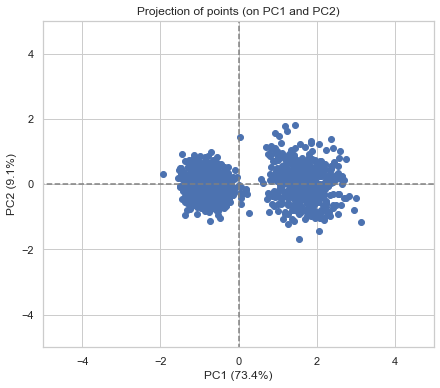

In [66]:
# Transformer les données standardisées en un nouveau vecteur
X_projected = pca.transform(billets_clustered)

# scatter plot des données
display_factorial_planes(X_projected, num_components, pca, [(0,1)])

plt.show()

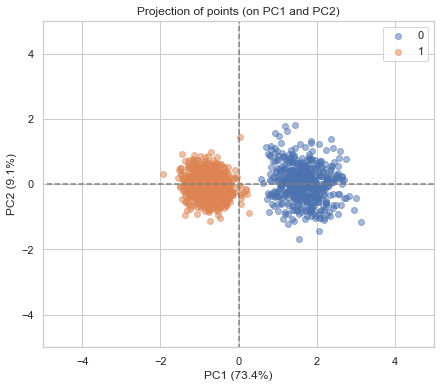

In [67]:
# Scatterplot differenciés des données
display_factorial_planes(X_projected, num_components, pca, [(0,1)], illustrative_var = billets_clustered['cluster'], alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

Représente 80% de nos données du df

Text(0.5, 1.0, 'Matrice de confusion K-means\n')

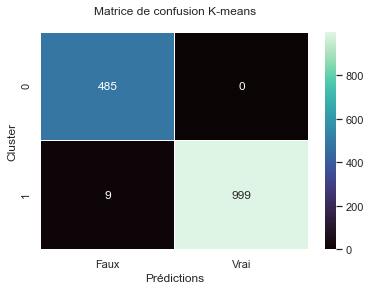

In [68]:
# Matrice de confusion des k-means
km_matrix = pd.crosstab(billets_clustered['cluster'],billets["is_genuine"])
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

Apparition des faux positifs dans le cluters 1 qui ne concerne que les billets qui sont censés être seulement positifs, confirmation de cette observation vu précédemment. 

## Conclusion

Les deux modèles, la regression logistique et le Kmeans renvoient tous les deux de très bon resultats mais l'apparition de faux positifs dans le kmeans est un critère à prendre en compte dans notre choix. 
Nous retenons la regression logistique pour éviter les erreurs. 

## Enregistrement du modèle pour le généraliser.

In [69]:
#Enregistrement du modèle et récupérer leurs valeurs ultérieurement.
#import pickle
#filename = 'final_model.sav'
#pickle.dump(LogisticRegression, open(filename, 'wb'))

### Fichier à tester 

In [70]:
# Import fichier test
test = pd.read_csv('billets_production.csv')
test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [71]:
# Drop de la colonne 'id' qui n'est pas utile
test1 = test.drop(columns=['id'])

In [72]:
# Verification de la composition du df après le drop
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
dtypes: float64(6)
memory usage: 368.0 bytes


In [73]:
# Entrainement du modèle retenu
y_pred_last = model_log.predict(test1)

In [74]:
# Affichage du résultat obtenu
y_pred_last

array([False, False, False,  True,  True])

In [75]:
# Affichage du résultat sous forme de df avec les prédictions du modèle
test1['is_genuine'] = y_pred_last
test1

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,False
1,171.87,104.17,104.13,6.00,3.31,112.09,False
2,172.00,104.58,104.29,4.99,3.39,111.57,False
3,172.49,104.55,104.34,4.44,3.03,113.20,True
4,171.65,103.63,103.56,3.77,3.16,113.33,True
